In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
from smyleutils import averaging_utils as avg
from smyleutils import histoplot_utils as histo
from smyleutils import bootstrap_utils as boot

from CASutils import bootstrap_utils as bootcas
from CASutils import linfit_utils as linfit
from CASutils import plothisto_utils as histo

import sys

In [2]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

In [3]:
high_nov=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E-L83_day_init11.nc').Uzm
low_nov=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E_day_init11.nc').Uzm ; low_nov['lat'] = high_nov.lat
era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init11.nc').Uzm ; era5_nov['lat'] = high_nov.lat
jra3q_nov = xr.open_dataset(basepath+'Uzm_JRA3Q_day_init11.nc').Uzm ; jra3q_nov['lat'] = high_nov.lat

### Compute the monthly average anomalies and grab out January

In [4]:
high_nov_mon = high_nov.groupby('time.month').mean('time')
low_nov_mon = low_nov.groupby('time.month').mean('time')
era5_nov_mon = era5_nov.groupby('time.month').mean('time')
jra3q_nov_mon = jra3q_nov.groupby('time.month').mean('time')

In [5]:
high_nov_mon = high_nov_mon - high_nov_mon.mean('init_year')
low_nov_mon = low_nov_mon - low_nov_mon.mean('init_year')
era5_nov_mon = era5_nov_mon - era5_nov_mon.mean('init_year')
jra3q_nov_mon = jra3q_nov_mon - jra3q_nov_mon.mean('init_year')

In [6]:
high_nov_mon = high_nov_mon.sel(month=1)
low_nov_mon = low_nov_mon.sel(month=1)
era5_nov_mon = era5_nov_mon.sel(month=1)
jra3q_nov_mon = jra3q_nov_mon.sel(month=1)

### Grab out the QBO and polar vortex levels

In [7]:
high_nov_50 = high_nov_mon.interp(ilev=50)
low_nov_50 = low_nov_mon.interp(ilev=50)
era5_nov_50 = era5_nov_mon.sel(level=50)
jra3q_nov_50 = jra3q_nov_mon.sel(pre=50)

In [8]:
high_nov_10 = high_nov_mon.interp(ilev=10)
low_nov_10 = low_nov_mon.interp(ilev=10)
era5_nov_10 = era5_nov_mon.sel(level=10)
jra3q_nov_10 = jra3q_nov_mon.sel(pre=10)

### Calculate the tropical average zonal mean zonal wind

In [14]:
era5_nov_tr = avg.cosweightlat(era5_nov_50,-5,5)
jra3q_nov_tr = avg.cosweightlat(jra3q_nov_50,-5,5)
high_nov_tr = avg.cosweightlat(high_nov_50,-5,5)
low_nov_tr = avg.cosweightlat(low_nov_50,-5,5)

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


In [15]:
era5_nov_pv = era5_nov_10.interp(lat=60)
jra3q_nov_pv = jra3q_nov_10.interp(lat=60)
high_nov_pv = high_nov_10.interp(lat=60)
low_nov_pv = low_nov_10.interp(lat=60)

### Correlation between QBO and polar vortex

In [16]:
era5_nov_cor = xr.corr(era5_nov_tr, era5_nov_pv, dim='init_year' )
jra3q_nov_cor = xr.corr(jra3q_nov_tr, jra3q_nov_pv, dim='init_year')
high_nov_cor = xr.corr(high_nov_tr.mean('M'), high_nov_pv.mean('M'), dim='init_year')
low_nov_cor = xr.corr(low_nov_tr.mean('M'), low_nov_pv.mean('M'), dim='init_year')

### Regresion of polar vortex onto QBO

In [18]:
aera5, bera5 = linfit.linfit_xy(era5_nov_tr, era5_nov_pv)
ajra3q, bjra3q = linfit.linfit_xy(jra3q_nov_tr, jra3q_nov_pv)
ahigh, bhigh = linfit.linfit_xy(high_nov_tr.mean('M'), high_nov_pv.mean('M'))
alow, blow = linfit.linfit_xy(low_nov_tr.mean('M'), low_nov_pv.mean('M'))

### Bootstrapped single member samples

In [19]:
boot_pv = [] ; boot_qbo = []
for iyear in np.arange(0,high_nov_pv.init_year.size,1):
    boot_pv_temp = boot.bootgen(high_nov_pv.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo_temp = boot.bootgen(high_nov_tr.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_pv.append(boot_pv_temp)
    boot_qbo.append(boot_qbo_temp)
boot_pv = xr.concat(boot_pv, dim=high_nov_tr.init_year)
boot_qbo = xr.concat(boot_qbo, dim=high_nov_tr.init_year)

boot_cor = xr.corr(boot_qbo, boot_pv, dim='init_year')

### Bootstrapped single member sample correlation and regression coefficients

In [20]:
boot_b = []
boot_var_noqbo=[]
boot_var = []
boot_var_qbo = []
for i in np.arange(0,boot_cor.iboot.size,1):
    thisqbo = boot_qbo.isel(iboot=i) 
    thispv = boot_pv.isel(iboot=i)
    a, b = linfit.linfit_xy(thisqbo, thispv)
    boot_b.append(xr.DataArray(b))
    
    pvnoqbo = thispv - (a + b*thisqbo)
    pvnoqbo_var = pvnoqbo.var('init_year')
    boot_var_noqbo.append(pvnoqbo_var)
    
    uqbo = a + b*thisqbo
    uqbo_var = uqbo.var('init_year')
    boot_var_qbo.append(uqbo_var)
    
    utotal_var = thispv.var('init_year')
    boot_var.append(utotal_var)
    
boot_b = xr.concat(boot_b, dim='iboot')
boot_var = xr.concat(boot_var, dim='iboot')
boot_var_noqbo = xr.concat(boot_var_noqbo, dim='iboot')
boot_var_qbo = xr.concat(boot_var_qbo, dim='iboot')

a, b_era5 = linfit.linfit_xy(era5_nov_tr, era5_nov_pv)
era5_pv_noqbo = era5_nov_pv - (a + b_era5*era5_nov_tr)
era5_var_noqbo = era5_pv_noqbo.var('init_year')
era5_var = era5_nov_pv.var('init_year')
era5_pv_qbo = a + b_era5*era5_nov_tr
era5_var_qbo = era5_pv_qbo.var('init_year')

a, b_jra3q = linfit.linfit_xy(jra3q_nov_tr, jra3q_nov_pv)
jra3q_pv_noqbo = jra3q_nov_pv - (a + b_jra3q*jra3q_nov_tr)
jra3q_var_noqbo = jra3q_pv_noqbo.var('init_year')
jra3q_var = jra3q_nov_pv.var('init_year')
jra3q_pv_qbo = a + b_jra3q*jra3q_nov_tr
jra3q_var_qbo = jra3q_pv_qbo.var('init_year')

### Plotting the plot

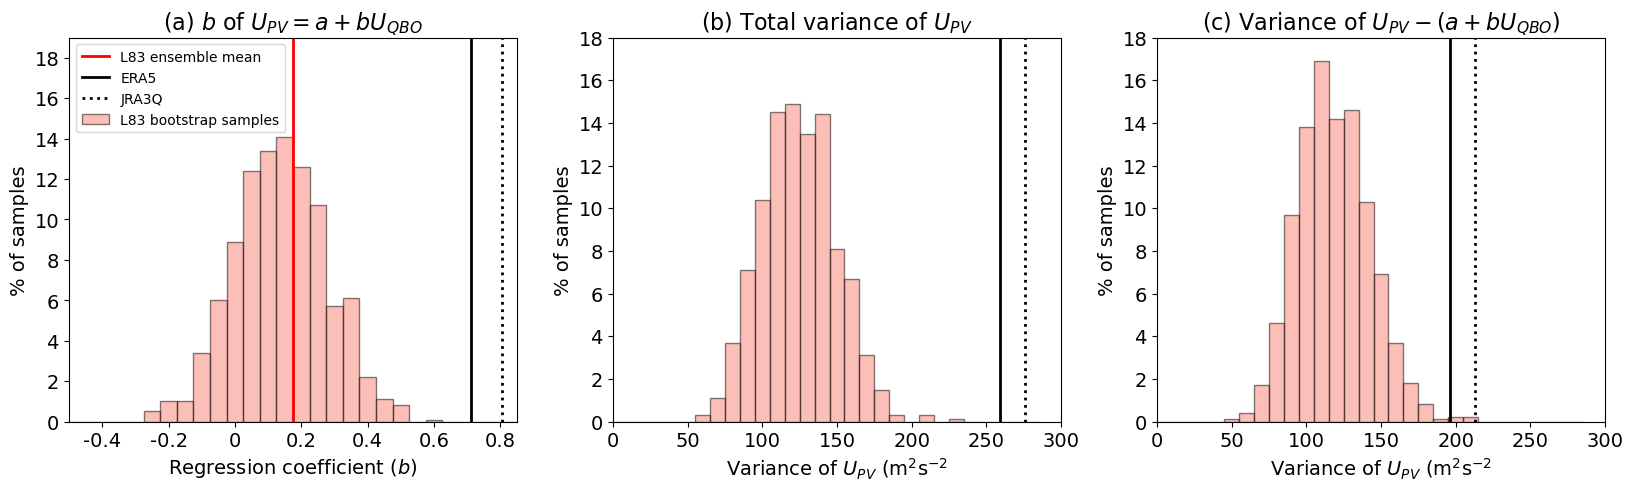

In [21]:
fig = plt.figure(figsize=(16,16))

ax = histo.plothisto(fig, boot_b, np.arange(-1,1,0.05), 0.02,0.3,0.76,1,percent=True, color='salmon', alpha=0.5, xlim=[-0.5,0.85], ylim=[0,19], label='L83 bootstrap samples')
ax.plot([bhigh, bhigh],[0,19], color='red', linewidth=2, label='L83 ensemble mean')
ax.plot([b_era5, b_era5],[0,19], color='black', linewidth=2, label='ERA5')
ax.plot([b_jra3q,b_jra3q], [0,19], color='black', linestyle='dotted', linewidth=2, label='JRA3Q')
ax.set_yticks([0,2,4,6,8,10,12,14,16,18])
ax.set_yticklabels(['0','2','4','6','8','10','12','14','16','18'], fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.set_xticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8])
ax.set_xticklabels(['-0.4','-0.2','0','0.2','0.4','0.6','0.8'], fontsize=14)
ax.set_xlabel('Regression coefficient ($b$)', fontsize=14)
ax.set_title('(a) $b$ of $U_{PV} = a + bU_{QBO}$', fontsize=16)
ax.legend(loc='upper left')


ax = histo.plothisto(fig, boot_var, np.arange(0,300,10), 0.36,0.64,0.76,1,percent=True, color='salmon', alpha=0.5, xlim=[0,300], ylim=[0,18])
ax.plot([era5_var, era5_var],[0,19], color='black', linewidth=2)
ax.plot([jra3q_var, jra3q_var], [0,19], color='black', linestyle='dotted', linewidth=2)
ax.set_yticks([0,2,4,6,8,10,12,14,16,18])
ax.set_yticklabels(['0','2','4','6','8','10','12','14','16','18'], fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.set_xticks([0,50,100,150,200,250,300])
ax.set_xticklabels(['0','50','100','150','200','250','300'], fontsize=14)
ax.set_xlabel('Variance of $U_{PV}$ (m$^{2}$s$^{-2}$', fontsize=14)
ax.set_title('(b) Total variance of $U_{PV}$', fontsize=16)


ax = histo.plothisto(fig, boot_var_noqbo, np.arange(0,300,10), 0.7,0.98, 0.76, 1, percent=True, color='salmon', alpha=0.5, xlim=[0,300], ylim=[0,18])
ax.plot([era5_var_noqbo, era5_var_noqbo],[0,19], color='black', linewidth=2)
ax.plot([jra3q_var_noqbo, jra3q_var_noqbo], [0,19], color='black', linestyle='dotted', linewidth=2)
ax.set_yticks([0,2,4,6,8,10,12,14,16,18])
ax.set_yticklabels(['0','2','4','6','8','10','12','14','16','18'], fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.set_xticks([0,50,100,150,200,250,300])
ax.set_xticklabels(['0','50','100','150','200','250','300'], fontsize=14)
ax.set_xlabel('Variance of $U_{PV}$ (m$^{2}$s$^{-2}$', fontsize=14)
ax.set_title('(c) Variance of $U_{PV} - (a + b U_{QBO})$', fontsize=16)

fig.savefig(plotpath+'fig7.png', bbox_inches='tight', facecolor='white')